<a href="https://colab.research.google.com/github/Murcha1990/LLM_Course_2026/blob/main/Hometasks/HSE_LLMCourse_Hometask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание:

## Часть 1 (5 баллов). BiLSTM для задачи PoS Tagging

В этом задании мы будем создавать модель машинного обучения, которая генерирует результат для каждого элемента входной последовательности с использованием PyTorch и TorchText. Конкретно, мы будем подавать текст на вход, а модель будет выводить метку - часть речи (PoS) для каждого токена во входном тексте. Этот подход также может применяться для распознавания именованных сущностей (NER), где результатом для каждого токена будет указание на тип сущности, если таковая имеется.

В этом задании мы реализуем многослойную двунаправленную LSTM (BiLSTM) для предсказания меток частей речи с использованием набора данных Universal Dependencies English Web Treebank (UDPOS).

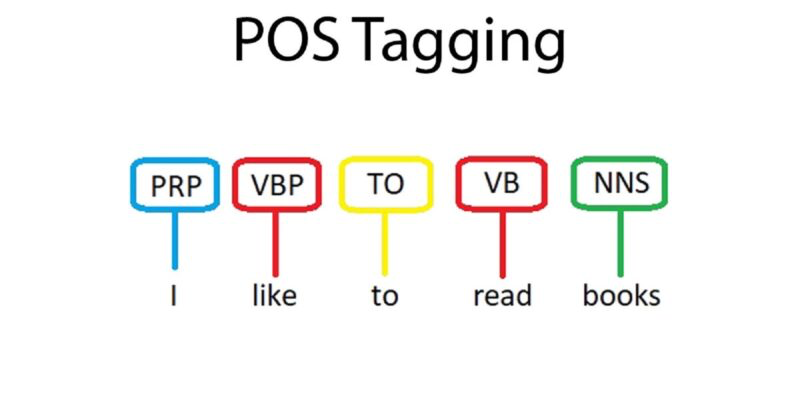

In [ ]:
!pip install torchtext==0.6.0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import spacy
import numpy as np

import time
import random

Зафиксируем случайности для воспроизводимости результатов.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

В этом наборе данных есть два разных набора меток: метки универсальных зависимостей (UD) и метки Penn Treebank (PTB). Мы будем обучать модель только на метках UD, но загрузим метки PTB, чтобы показать, как их можно использовать вместо них.

* UD_TAGS определяет, как следует обрабатывать метки UD. В нашем словаре TEXT, который мы создадим позже, будут неизвестные токены, то есть токены, которых нет в нашем словаре. Однако у нас не будет неизвестных меток, поскольку мы имеем дело с конечным набором возможных меток. Мы будем обозначать неизвестные токены как <unk>, и затем будем их убирать, установив unk_token = None.

* PTB_TAGS выполняет то же самое, что и UD_TAGS, но обрабатывает метки PTB.

In [ ]:
from torchtext.data import Field

TEXT = Field(lower = True)
UD_TAGS = Field(unk_token = None)
PTB_TAGS = Field(unk_token = None)

In [ ]:
fields = (("text", TEXT), ("udtags", UD_TAGS), ("ptbtags", PTB_TAGS))

Загрузим датасет UDPOS.

In [ ]:
train_data, valid_data, test_data = datasets.UDPOS.splits(fields)

## Задание

Посмотрите на количество объектов в датасетах `train_data, valid_data и test_data`. В ответ запишите число объектов в самом маленьком датасете.

In [ ]:
# ваш код здесь

Напечатаем пример из датасета

In [ ]:
print(vars(train_data.examples[0]))

Можем отдельно посмотреть на текст и на теги

In [ ]:
print(vars(train_data.examples[0])['text'])

In [ ]:
print(vars(train_data.examples[0])['udtags'])

In [ ]:
print(vars(train_data.examples[0])['ptbtags'])

Что мы сделаем дальше:

* Мы создадим словарь - отображение токенов в целые числа.

* Мы хотим, чтобы в нашем наборе данных были некоторые неизвестные токены, чтобы воссоздать, как эта модель будет использоваться в реальной жизни, поэтому мы устанавливаем `min_freq = 2`, что означает, что в словарь будут добавлены только токены, появляющиеся хотя бы дважды в обучающем наборе, и остальные будут заменены токенами `<unk>`.

* Мы также загружаем предобученные векторы GloVe длины 100 для инициализации эмбеддингов.

* `unk_init` используется для инициализации эмбеддингов токенов, которых нет в словаре предварительно обученных вложений. По умолчанию эта инициализация устанавливает эти эмбеддинги в нули, однако лучше избежать их инициализации одним и тем же значением, поэтому мы инициализируем их из нормального распределения.

* Предобученные векторы загружаем в наш словарь и будем инициализировать нашу модель этими значениями позже.

## Задание

По тренировочным данным постройте три словаря, используя `build_vocab`:

* Cловарь по текстам `TEXT` с гиперпараметрами:
  * min_freq = MIN_FREQ
  * vectors = "glove.6B.100d"
  * unk_init = torch.Tensor.normal_

* Словарь по `UD_TAGS`

* Словарь по `PTB_TAGS`

Сколько уникальных токенов в словаре, построенном по текстам?

In [ ]:
MIN_FREQ = 2

# ваш код здесь

## Задание

Какой самый популярный (часто встречающийся) токен в словаре, построенном по текстам?

In [ ]:
# ваш код здесь

Посмотрим на функцию, вычисляющую процентное соотношение тегов в текстах.

In [ ]:
def tag_percentage(tag_counts):

    total_count = sum([count for tag, count in tag_counts])

    tag_counts_percentages = [(tag, count, count/total_count) for tag, count in tag_counts]

    return tag_counts_percentages

## Задание

Пользуясь функцией `tag_percentage`, выведите на экран процентное соотношение каждого UD-тэга.

Какой тег встречается в текстах чаще всего (в процентах)?

In [ ]:
# ваш код здесь

## Задание

Используя `BucketIterator.split` ([пример использования](https://docs.pytorch.org/text/0.8/examples.html)), создайте объекты `train_iterator, valid_iterator, test_iterator` для итерирования по батчам.

In [ ]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = # ваш код здесь

## Создаем архитектуру нейронной сети

![](https://github.com/bentrevett/pytorch-pos-tagging/blob/master/assets/pos-bidirectional-lstm.png?raw=1)

Задайте нейронную сеть со следующей архитектурой:

* Слой Embedding:
  * помимо прочего задайте `padding_idx = pad_idx`

* Затем слой LSTM с гиперпараметрами:
  * `n_layers = 1`
  * `bidirectional = True`
  * задайте `dropout`

* Затем DropOut слой

* Линейный слой, принимающий на вход `hidden_dim * 2` нейронов (так как двунаправленная сеть) и на выходе `output_dim` нейронов

In [ ]:
class BiLSTMPOSTagger(nn.Module):
    def __init__(self,
                 input_dim,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout,
                 pad_idx):

        super().__init__()

        # ваш код здесь


    def forward(self, text):

        #pass text through embedding layer and then through dropout layer
        embedded = # ваш код здесь

        #pass embeddings into LSTM
        outputs, (hidden, cell) = # ваш код здесь

        #apply dropout and then linear layer
        predictions = # ваш код здесь

        return predictions

## Обучение модели

## Задание

Запустите ячейку ниже. Если класс `BiLSTMPOSTagger` реализован корректно, ячейка отработает без ошибок.

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(UD_TAGS.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = BiLSTMPOSTagger(INPUT_DIM,
                        EMBEDDING_DIM,
                        HIDDEN_DIM,
                        OUTPUT_DIM,
                        N_LAYERS,
                        BIDIRECTIONAL,
                        DROPOUT,
                        PAD_IDX)

Инициализируем веса сети числами из стандартного нормального распределения

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)

model.apply(init_weights)

## Задание

Напишите функцию для вычисления количества весов сети.

С помощью этой функции выведите на экран число весов нашей сети.

In [ ]:
def count_parameters(model):
    # ваш код здесь

# ваш код здесь

## Задание

Инициализируйте embedding-слой сети предобученными GloVe-векторами.

In [ ]:
# ваш код здесь

Инициализируем нулями pad-токены

In [ ]:
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

Зададим оптимизатор

In [ ]:
optimizer = optim.Adam(model.parameters())

Зададим loss.

В случае токена `<pad>` (пустота) лосс мы не считаем, поэтому индексы таких токенов мы пропускаем (игнорируем).

In [ ]:
TAG_PAD_IDX = UD_TAGS.vocab.stoi[UD_TAGS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

Переносим модель на GPU по возможности

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

Функция ниже вычисляет `accuracy` для каждого батча

In [ ]:
def categorical_accuracy(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / y[non_pad_elements].shape[0]

## Задание

Допишите цикл обучения модели.

Для каждого батча на каждой итерации:
- зануляем градиенты
- применяем модель к батчу
- делаем reshape прогнозов, так как loss нельзя вычислить для тензора размерности 3 (это уже написано)
- вычисляем loss и accuracy
- вычисляем градиенты и делаем шаг градиентного спуска

In [ ]:
def train(model, iterator, optimizer, criterion, tag_pad_idx):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        # ваш код здесь

        predictions = predictions.view(-1, predictions.shape[-1]) # predictions - прогнозы модели
        tags = tags.view(-1) # tags - правильные ответы (метки)

        # ваш код здесь

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Функцию `evaluate` для простоты мы написали.

In [ ]:
def evaluate(model, iterator, criterion, tag_pad_idx):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            text = batch.text
            tags = batch.udtags

            predictions = model(text)

            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            loss = criterion(predictions, tags)

            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Ниже функция, которая замеряет время обучения на каждой эпохе

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Задание

Обучим нашу модель. Допишите цикл по подсказкам в коде.

Какая accuracy (в процентах) получается на валидации на последней эпохе?

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = # ваш код здесь - примените функцию для обучения модели
    valid_loss, valid_acc = # ваш код здесь - примените функцию для применения и оценки качества модели

    end_time = time.time()

    epoch_mins, epoch_secs = # замерьте время выполнения эпохи, используя написанную для этого функцию

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')


    # для каждой эпохи выведите train loss, train accuracy, val loss, val accuracy, epoch time
    # ваш код здесь

Посмотрим на качество обученной модели на тесте

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

## Инференс

Посмотрим, как модель работает на новых данных. Допишите функцию `tag_sentence` для применения обученной модели, по подсказкам ниже.

In [ ]:
def tag_sentence(model, device, sentence, text_field, tag_field):

    # ваш код здесь - переведите модель в режим применения

    if isinstance(sentence, str):
        nlp = spacy.load('en_core_web_sm')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]

    numericalized_tokens = # ваш код здесь - создайте список, состоящий из переведенных в индексы токенов из словаря text_field.vocab (используйте stoi)

    unk_idx = text_field.vocab.stoi[text_field.unk_token]

    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]

    token_tensor = # ваш код здесь - приведите numericalized_tokens к типу torch.LongTensor

    token_tensor = token_tensor.unsqueeze(-1).to(device)

    predictions = # ваш код здесь - примените модель к token_tenzor

    top_predictions = predictions.argmax(-1)

    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]

    return tokens, predicted_tags, unks

## Задание

Запустите две следующие ячейки. Проверим, что написанная функция работает корректно.

Напишите несколько токенов, которые были не распознаны (их не было в обучающих данных).

In [ ]:
example_index = 1

sentence = vars(train_data.examples[example_index])['text']
actual_tags = vars(train_data.examples[example_index])['udtags']

print(sentence)

In [ ]:
tokens, pred_tags, unks = tag_sentence(model,
                                       device,
                                       sentence,
                                       TEXT,
                                       UD_TAGS)

print(unks)

## Задание

Проверим качество модели. Запустите ячейку ниже. Укажите число неверно классифицированных токенов.

In [ ]:
print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")

for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")

## Задание

Примените модель к любому предложению (на английском языке). Какая доля токенов размечена верно?

In [ ]:
# ваш код здесь

## Часть 2 (5 баллов). Дообучение BERT

Ваша следующая задача — поработать с генерацией эмбеддингов BERT, дообучить существующие модели на новых данных и убедиться в превосходстве трансформеров над предыдущими архитектурами (пусть и ценой более высоких вычислительных затрат).


In [ ]:
%pip install --upgrade transformers datasets accelerate deepspeed

import os
os.environ["WANDB_DISABLED"] = "true"

import torch
import transformers
import datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments

### Загрузим данные и модель

Наш сегодняшний датасет — **Quora Question Pairs (QQP)**.

Он состоит из более чем 400 000 пар вопросов, и каждая пара размечена бинарным значением, указывающим, являются ли два вопроса перефразированием друг друга, то есть семантически близкими. Подробнее можно почитать [здесь](https://paperswithcode.com/dataset/quora-question-pairs).

In [ ]:
qqp = datasets.load_dataset('SetFit/qqp')
print('\n')
print("Sample[0]:", qqp['train'][0])
print("Sample[3]:", qqp['train'][3])

In [ ]:
model_name = "gchhablani/bert-base-cased-finetuned-qqp"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

### Токенизация

Библиотека [datasets](https://huggingface.co/docs/datasets/en/index) позволяет использовать отображение (`mapping`) в стиле функционального программирования.

**Что происходит с текстами в `qqp_preprocessed`?**

* Исходные `text1` и `text2` токенизируются в числовые идентификаторы с помощью соответствующего токенизатора.
* Оба текста объединяются с помощью токена `SEP` и дополняются в начале токеном `CLS`, чтобы соответствовать требуемому формату. Получившаяся последовательность либо усекается (если суммарная длина превышает 128 токенов), либо дополняется паддингом (если длина меньше 128 токенов).
* Датасет `qqp_preprocessed` содержит:

  * *Input IDs*: последовательность идентификаторов токенов.
  * *Attention Masks*: бинарные маски, указывающие, какие токены являются паддингом.
  * *Token Type IDs*: различают токены, принадлежащие `text1` и `text2`.

**Примечание.** Attention masks здесь позволяют пропускать вычисления для токенов `PAD`.


In [ ]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

In [ ]:
print(repr(qqp_preprocessed['train'][0]['input_ids'])[:100], "...")

### Evaluation (2 балла)

Мы случайным образом выбрали модель, обученную на QQP — но насколько она хороша?

Один из способов это проверить — использовать точность на валидации, что вы и реализуете далее.

Вот интерфейс, который поможет вам это сделать:


Посмотрим на данные

In [ ]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1, shuffle=False, collate_fn=transformers.default_data_collator
)

In [ ]:
for batch in val_loader:
     break  # here be your training code
print("Sample batch:", batch)

with torch.no_grad():
  predicted = model(
      input_ids=batch['input_ids'],
      attention_mask=batch['attention_mask'],
      token_type_ids=batch['token_type_ids']
  )

print('\nPrediction (probs):', torch.softmax(predicted.logits, dim=1).data.numpy())

Обратите внимание, что модель использует 2 головы для бинарной классификации (по одной на каждый класс), а не одну. На самом деле это вопрос предпочтений.

**Ваша задача** — измерить точность модели на валидации.
Наивная реализация может занять несколько часов, поэтому обязательно используйте следующие оптимизации:

* запускайте модель на GPU и с `no_grad`
* используйте размер батча больше 1
* применяйте оптимизированный DataLoader с `num_workers > 1`
* (опционально) используйте [mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html)


Обратите внимание, что, хотя вычисления модели выполняются на GPU, процесс загрузки данных с диска (или из памяти) и приведения их к формату, необходимому для модели (например, тензорам), выполняется на CPU.

Недостаток вычислительных ресурсов CPU может привести к тому, что он станет bottleneck-ом всего процесса.


In [ ]:
from tqdm import tqdm
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

In [ ]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create a DataLoader for the validation set
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=16,  # Larger batch size for faster processing
    shuffle=False, collate_fn=transformers.default_data_collator,
    num_workers=cores  # Use multiple workers to load data faster
)

In [ ]:
# Measure validation accuracy
model.eval()  # Set model to evaluation mode

<YOUR CODE HERE>

# (optional) Enable mixed precision for faster computation if supported
scaler = torch.cuda.amp.GradScaler() if device == torch.device("cuda") else None

with torch.no_grad():  # Disable gradient calculation
    for batch in tqdm(val_loader, desc="Evaluating"):
        # Move batch to GPU
        <YOUR CODE HERE>

        # Use mixed precision if available
        if scaler:
            with torch.cuda.amp.autocast():
                outputs = <YOUR CODE HERE>
        else:
            outputs = <YOUR CODE HERE>

        # Get predictions and update accuracy
        <YOUR CODE HERE>

# Compute accuracy
accuracy = <YOUR CODE HERE> # Validation accuracy, between 0 and 1
print(f"Validation Accuracy: {accuracy:.4f}")

In [ ]:
assert 0.9 < accuracy < 0.91

### Обучение модели (3 балла)

В этом задании вам нужно дообучить собственную модель. Вы можете выбрать любую модель, **кроме оригинального BERT**. Мы рекомендуем [DeBERTa-v3](https://huggingface.co/microsoft/deberta-v3-base). А ещё лучше — выбрать лучшую модель на основе публичных бенчмарков (например, [GLUE](https://gluebenchmark.com/)).

Вы можете написать код обучения вручную или использовать `transformers.Trainer` (см. [этот пример](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification)). Пожалуйста, убедитесь, что точность вашей модели как минимум **сопоставима** с приведённым выше примером для BERT.


In [ ]:
# Load your model e.g. DeBERTa-v3 tokenizer and model
model_name = <THE MODEL OF YOUR CHOICE HERE>
tokenizer = <YOUR CODE HERE>
model = <YOUR CODE HERE>  # Binary classification. num_labels=1 if you prefer.

# Note that if the tokenizer of your model
# is different from the one we used aboVe,
# you need ot preprocess your data again.

# Preprocess the data
<YOUR CODE HERE>

# <If so, your code goes here>
qqp_preprocessed = <YOUR CODE HERE>

In [ ]:
# Prepare the training and validation sets
train_set = qqp_preprocessed['train']
val_set = qqp_preprocessed['validation']


# Define a metric for evaluation. You can write your own if you prefer
from sklearn.metrics import accuracy_score

# If you are using transformers.Trainer, you may want to use a utility function below
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics for the model during training or evaluation.
    Args:
        eval_pred (tuple): A tuple containing:
            - logits (ndarray or torch.Tensor): The raw logits output by the model for each sample
              in the evaluation batch. Shape: (batch_size, num_classes).
            - labels (ndarray or torch.Tensor): The ground truth labels for each sample in the batch.
              Shape: (batch_size,).
    Returns:
        dict: A dictionary containing the computed metric(s):
            - "accuracy" (float): The proportion of correct predictions over the total number of samples.
    """
    <YOUR CODE HERE>
    return {"accuracy": accuracy}

# Feel free not to use transformers.Trainer and write the code manually if you want
# A good starting learning rate is 2e-5.
# A step of an order of magnitude is a good way to adjust it if necessary e.g. 2e-4, 2e-3 etc.
# 3 train epochs is likely enough for gently finetuning the model without the model 'forgetting previous data'
# Be sure to use weight_decay i.e. regularisation. A good starting point is 1e-2. Feel free to experiment.
# Consider setting accuracy as the metric for the best model.

# Define your training arguments without the 'device' argument since it is handled automatically.
training_args = TrainingArguments(
    <YOUR CODE HERE>
)

# Initialize the Trainer
trainer = Trainer(
    <YOUR CODE HERE>
)

# Fine-tune the model
<YOUR CODE HERE>

# Evaluate the model
<YOUR CODE HERE>
print(f"Validation Accuracy: {accuracy:.4f}")


In [ ]:
assert 0.9 < accuracy

Если быть полностью честными, здесь мы совершили небольшое «преступление». Валидационная часть датасета предназначена для подбора гиперпараметров, но ради простоты мы опустили эту логику. При желании вы можете выбрать лучшие гиперпараметры и проверить результаты на подвыборке `test`.

### БОНУС: Почувствуйте, как работают эмбеддинги BERT

Пришло время пролить свет на то, как эмбеддеры на основе BERT могут использоваться для поиска релевантной информации.

Проблема «ванильного» BERT и подобных моделей в том, что они не обучаются напрямую с использованием контрастивной или триплетной функции потерь, которая действительно заставляет похожие эмбеддинги быть ближе друг к другу. Поэтому для получения наилучших результатов при построении поисковой системы предпочтительнее выбирать специализированную модель для [семантического сходства предложений](https://huggingface.co/models?pipeline_tag=sentence-similarity). Вы можете выбрать ту, которая лучше всего подходит под ваши требования.

Ваша задача — построить поисковую систему:

1. *Подготовьте базу эмбеддингов*: поскольку датасет Quora Question Pairs содержит пары вопросов, мы будем использовать только данные из поля `text1` в валидационной подвыборке (`validation`). Вам нужно получить эмбеддинги с помощью выбранной модели и сохранить их для дальнейшего использования в виде `numpy.ndarray`. Опционально можно воспользоваться специализированным индексом [Faiss](https://github.com/facebookresearch/faiss).

2. *Реализуйте поиск похожих вопросов для заданного запроса*: предполагается, что вы напишете функцию или класс, который упростит взаимодействие с вашей базой. **Завершённость этой части задания будет оцениваться по способности корректно выводить ТОП-5 наиболее похожих вопросов Quora для нового произвольного запроса.**

In [ ]:
# Initialize the model and its tokenizer
model_name = <MODEL OF YOUR CHOICE HERE>
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

<YOUR CODE HERE>

def find_similar_questions(query, database, model, top_k = 5):
    """
    Finds and prints the top_k most similar questions for a query.

    This function encodes a query, compares it against a pre-computed
    embedding database using cosine similarity, and prints the most
    semantically similar questions.

    Args:
        query (str): The user's search query.
        database (np.ndarray): A 2D NumPy array containing the pre-computed
                               embeddings for the database of questions.
        model (SentenceTransformer): The initialized Sentence-Transformer model
                                     used to encode the query.
        top_k (int): The number of top results to display.

    Returns:
        None. The function prints the results.
    """
    <YOUR CODE HERE>